Change: use full sized images, based on sigmoid-3 approach

# Melanoma with CNN

In [2]:
import tensorflow as tf
import matplotlib.image as mpimg
import os
# First, load the image
#dir_path = os.path.dirname(os.path.realpath(__file__))
filename = "./ISIC_0000000.jpg"

# Load the image
image = mpimg.imread(filename)

# Print out its shape
print(image.shape)


(767, 1022, 3)


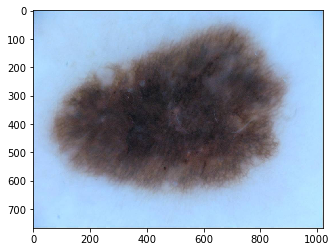

In [3]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

In [4]:
type(image)

numpy.ndarray

In [7]:
from scipy import ndimage, misc
import numpy as np
import re

images = []
for root, dirnames, filenames in os.walk("C:/Users/Admin/Documents/Skin Depth/Leads and Projects/Melanoma Challenge/2018/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input"):
    #print(root)
    for filename in filenames:
        if re.search("ISIC_\d*final_size.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            image_resized = misc.imresize(image, (96,128,3))  #redo this size or re-size later in Tensorflow ->STORE resized images later
            images.append(image_resized)
            filename = filename.split(".")
            name = filename[0] + "2." + filename[1]
            #print(name)
            
            new_path = os.path.join(root, name)
            f = open(new_path, 'w+b')
            misc.imsave(new_path, image_resized)
            f.close()
images = np.array(images)

In [8]:
images.shape
                       


(2594, 96, 128, 3)

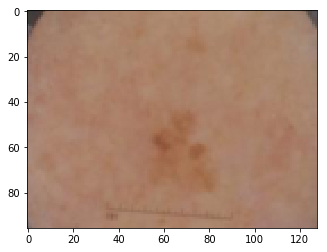

In [9]:
image = images[2593,:,:,:]
plt.imshow(image)
plt.show()

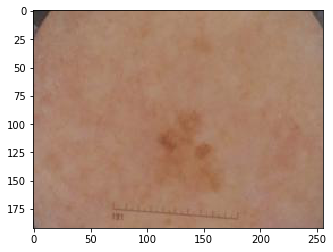

In [11]:
image = image = ndimage.imread(filepath, mode="RGB")
plt.imshow(image)
plt.show()

In [14]:
#C:/Users\Admin\Documents\Skin Depth\Leads and Projects\Melanoma Challenge\2018\ISIC2018_Task1_Training_GroundTruth\ISIC2018_Task1_Training_GroundTruth
segs = []
for root, dirnames, filenames in os.walk("C:/Users/Admin/Documents/Skin Depth/Leads and Projects/Melanoma Challenge/2018/ISIC2018_Task1_Training_GroundTruth/ISIC2018_Task1_Training_GroundTruth"): 
    for filename in filenames:
        if re.search("\w*_final_size.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            seg = ndimage.imread(filepath, mode="L")
            seg_resized = misc.imresize(seg, (96,128,1))  #redo this size or re-size later in Tensorflow
            segs.append(seg_resized.tolist())
            filename = filename.split(".")
            name = filename[0] + "2." + filename[1]
            #print(name)
            
            new_path = os.path.join(root, name)
            f = open(new_path, 'w+b')
            misc.imsave(new_path, seg_resized)
            #os.remove(filepath)
            f.close()
segs = np.array(segs)


In [15]:
segs.shape

(2594, 96, 128)

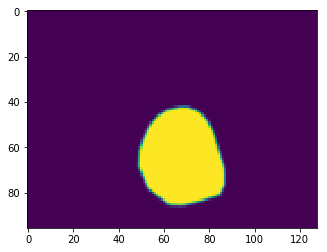

In [16]:
image = segs[2593,:,:]
plt.imshow(image)
plt.show()

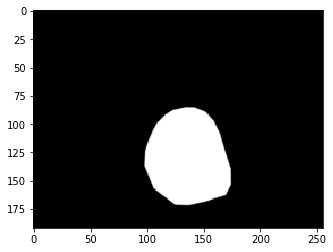

In [17]:
image = image = ndimage.imread(filepath, mode="RGB")
plt.imshow(image)
plt.show()

### Helper Functions

Function to help intialize random weights for fully connected or convolutional layers, we leave the shape attribute as a parameter for this.

In [18]:
from sklearn.model_selection import train_test_split
trainim, testim, trainlab, testlab = train_test_split(images, segs, test_size = 0.3) #this is randomized each time the program is started and run from scratch

In [19]:
trainim.shape

(1815, 96, 128, 3)

In [20]:
np.max(testlab)

255

In [21]:
testlab.shape

(779, 96, 128)

In [22]:
training_labels = np.around(trainlab/255)

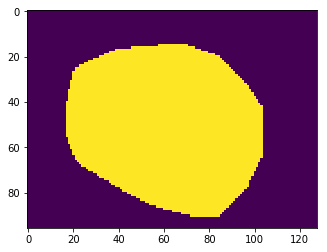

In [23]:
image = training_labels[5,:,:]
plt.imshow(image)
plt.show()

In [57]:
class MelHelper():
    
    def __init__(self):
        self.i = 0
        
        ####Can probably eliminate this part ####
        
        # Grabs a list of all the data batches for training
        #self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        #self.test_batch = [test_batch]
        
        ###eliminate####
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        ###Not Needed####
        # Vertically stacks the training images
        #self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])  #insert images here, make sure they are 
        #vetically stacked##
        #train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = trainim/255   #normalize only ->replace with images with training set later
                                #self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        
        ##May need to replace this with code that rounds a humber to 0 or 1 for the mask ##
        self.training_labels = np.around(trainlab/255) #one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        #self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        #test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = testim/255 #self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = np.around(testlab/255).reshape(-1,96*128) #one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        xtra = (self.i + batch_size) % len(self.training_images)
        if xtra<100 and xtra != 0:
            x = np.vstack((self.training_images[self.i:self.i+batch_size], self.training_images[0:xtra])) #.reshape(100,32,32,3)  #why is this necessary?
            y = np.vstack((self.training_labels[self.i:self.i+batch_size].reshape(-1,96*128), self.training_labels[0:xtra].reshape(-1,96*128)))
        else:
            x = self.training_images[self.i:self.i+batch_size] #.reshape(100,32,32,3)  #why is this necessary?
            y = self.training_labels[self.i:self.i+batch_size].reshape(-1,96*128)
        
        self.i = xtra 
        return x, y

In [25]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [26]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Create a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.


In [27]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def deconv2d(x, W, outputshape):
    return tf.nn.conv2d_transpose(x, W, output_shape = outputshape, strides=[1, 1, 1, 1], padding='SAME')

Create a max pooling layer, again using built in TF functions:

Performs the max pooling on the input.

    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. 

In [28]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we'll return an actual convolutional layer here that uses an ReLu activation.

In [29]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

This is a normal fully connected layer

In [30]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def deconvolutional_layer(input_x, filter_shape, output_shape):
    W = init_weights(filter_shape)
    b = init_bias(filter_shape[3])  #draw this out to see if it makes sense
    return tf.nn.relu(deconv2d(input_x, W, outputshape) +b)

### Placeholders

In [33]:
x = tf.placeholder(tf.float32,shape=[None,96,128,3])  #trace the shaping of these through the code...


In [34]:
y_true = tf.placeholder(tf.float32,shape=[None,96*128])  #this now has every pixel in the ground truth segmentation

### Layers

In [35]:
x_image = tf.reshape(x,[-1,96,128,3])  #-1 infers the shape of the first dimension (here, the batch size)

In [36]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can change the 32 output, that essentially represents the amount of filters used
# You need to pass in 32 to the next input though, the 1 comes from the original input of 
# a single image.
convo_1 = convolutional_layer(x_image,shape=[3,3,3,4])
convo_1_pooling = max_pool_2by2(convo_1)

In [37]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,4,16])
#convo_2_pooling = max_pool_2by2(convo_2)

In [28]:
#print(convo_2_pooling.shape)

In [38]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_3 = convolutional_layer(convo_2,shape=[3,3,16,32])
convo_3_pooling = max_pool_2by2(convo_3)

In [39]:
print(convo_3_pooling.shape)

(?, 24, 32, 32)


In [40]:
# Using a 6by6 filter here, used 5by5 in video, you can play around with the filter size
# You can actually change the 64 output if you want, you can think of that as a representation
# of the amount of 6by6 filters used.
convo_4 = convolutional_layer(convo_3_pooling,shape=[3,3,32,64])
#convo_4_pooling = max_pool_2by2(convo_4)

In [41]:
#print(convo_4_pooling.shape)

In [42]:
convo_5 = convolutional_layer(convo_4,shape=[3,3,64,128])
convo_5_pooling = max_pool_2by2(convo_5)

In [43]:
print(convo_5_pooling.shape)

(?, 12, 16, 128)


In [44]:
convo_6 = convolutional_layer(convo_5_pooling,shape=[3,3,128,256])
convo_6_pooling = max_pool_2by2(convo_6)

In [45]:
print(convo_6_pooling.shape)

(?, 6, 8, 256)


In [46]:
deconv_1 = deconvolutional_layer(convo_6_pooling, shape = [3,3,256,128]) #tansforms 256 features to 128
deconv_1_ups = ups_2by2(deconv_1)  #these need definition

(?, 12288)


In [49]:
# NOTE THE PLACEHOLDER HERE!
hold_prob = tf.placeholder(tf.float32)

full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [50]:
full_layer_two = tf.nn.relu(normal_full_layer(full_one_dropout,96*128))


In [41]:
#full_layer_three = tf.nn.relu(normal_full_layer(full_layer_two,192*256))


deconv_layer_one = 

## Augment the output with a direct connection to the input photo

#do not use for now

flat_in = tf.reshape(x,[-1,1764])
aug = tf.concat([flat_in, full_one_dropout], axis = 1)
print(flat_in.shape)
print(full_one_dropout.shape)
print(aug.shape)
##need to think about how to concatenate these


full_one_plus_in = tf.convert_to_tensor(aug, dtype=tf.float32)

type(full_one_dropout)

In [51]:
y_pred = normal_full_layer(full_layer_two,96*128)

### Loss Function

In [52]:
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Optimizer

In [53]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)   #can this be done for each pixel?

### Intialize Variables

In [54]:
init = tf.global_variables_initializer()

### Session

In [59]:
mel = MelHelper()
mel.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [ ]:
steps = 500*130
import time
batch_size = 20

#use Cifar_helper to set up next batch
with tf.Session() as sess:
    sess.run(init)
    print("done init")
    
    start_time = time.clock()
    
    for i in range(steps): 
        batch_x, batch_y = mel.next_batch(batch_size)
        
        #print("\n")
        #print("batch training labels shape is ", batch_y.shape)
        #print("batch training labels type is ", batch_y.dtype)
        #print("batch training labels are ", batch_y)
        #print("batch training data are ", batch_x)
        #image = batch_y.reshape(-1,21,28)[5,:,:]
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        #print("batch training prediction are ", batch_y)
        #image_pred = sess.run(y_pred,feed_dict={x:batch_x,y_true:batch_y,hold_prob:1.0} ).reshape(-1,21,28)[5,:,:]
        #image_pred = np.round(1/(1 + np.exp(-image_pred)))
    
        if i%500 == 0:
             #print('Currently on step {}'.format(i))
             #print("mel i is ", mel.i)
             #plt.imshow(image)
             #plt.show()
             #plt.imshow(image_pred)
             #plt.show()
            
            #print('Currently on step {}'.format(i))
            #print('Accuracy is:')
            # Test the Train Model
            #matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            #acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            
          
            # Test the Train Model
            #matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))  ###REPLACE THIS LINE TO INCLUDE JACARD INDEX####
            #y_pred = tf.round(y_pred)
            #y_true = tf.round(y_true)
            pred = tf.round(1/(1 + tf.exp(-tf.reshape(y_pred, [-1,96,128]))))
            true = tf.reshape(y_true, [-1,96,128])
            intersect = tf.reduce_sum(tf.cast(true*pred, tf.float32), axis = [1,2])
            union = tf.reduce_sum(tf.cast(pred, tf.float32), axis = [1,2]) + tf.reduce_sum(tf.cast(true, tf.float32), axis = [1,2]) - intersect  #think this has an error
            jacc = intersect/union
            #acc = tf.reduce_mean(tf.cast(intersect,tf.float32))
            #print("test labels shape is ", mel.test_labels.shape)
            #print("\n")
            
            print('Avg Jacc is:')
            J_out = sess.run(jacc,feed_dict={x:mel.test_images,y_true:mel.test_labels,hold_prob:1.0})
            print(np.sum(J_out)/J_out.shape[0], " step number is ",  i, " batch_size is ", batch_size)
            #if i == 500:
                #batch_size = 20
            #if i == 25000:
                #batch_size = 200
            
            #print out Jacc for training set and test set, Save Jacc and entropy to variable,
            #print out step number
            #use larger pics
            #print out and analyse cross entropy
            #run with full training batch for several iterations

done init
Avg Jacc is:
0.15629793101  step number is  0  batch_size is  20
Avg Jacc is:
0.37699410239  step number is  500  batch_size is  20
Avg Jacc is:
0.374683149972  step number is  1000  batch_size is  20
Avg Jacc is:
0.377606020965  step number is  1500  batch_size is  20
Avg Jacc is:
0.373144343208  step number is  2000  batch_size is  20
Avg Jacc is:
0.377500404289  step number is  2500  batch_size is  20
Avg Jacc is:
0.371818062583  step number is  3000  batch_size is  20
Avg Jacc is:
0.376801124739  step number is  3500  batch_size is  20
Avg Jacc is:
0.369295524235  step number is  4000  batch_size is  20
Avg Jacc is:
0.37471785931  step number is  4500  batch_size is  20
Avg Jacc is:
0.370170152539  step number is  5000  batch_size is  20
Avg Jacc is:
0.371500154821  step number is  5500  batch_size is  20
Avg Jacc is:
0.370425497307  step number is  6000  batch_size is  20
Avg Jacc is:
0.368216361559  step number is  6500  batch_size is  20
Avg Jacc is:
0.37374247207  ste

In [ ]:
batch_x

In [ ]:
J_out



In [ ]:
out_list = plt.hist(J_out, bins = 20, data = True)

In [ ]:
plt.show()

In [ ]:
out_list


In [ ]:
success_rate_08 = np.sum(out_list[0][-5:])
success_rate_08/779

In [ ]:
success_rate_07 = np.sum(out_list[0][-7:])
success_rate_07/779

## Great Job!